In [0]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, \
    GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

max_queried = 500

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
# read data as pandas data frame
import io
data =  pd.read_csv(io.BytesIO(uploaded['data.csv']))
data = data.drop(['Unnamed: 32', 'id'], axis = 1)
y = data.diagnosis # Malign or Benign (Gutartig vs Boesartig)
liste = ['diagnosis']
x = data.drop(liste, axis = 1 )

In [0]:
trainset_size = 60000 # ie., testset_size = 10000

def download():
 #mnist = fetch_openml('MNIST original')
 mnist = fetch_openml('mnist_784')
 #mnist = fetch_openml('nomao')
 X = mnist.data.astype('float64')
 y = mnist.target
 print ('MNIST:', X.shape, y.shape)
 return (X, y)

def split(train_size):
 X_train_full = X[:train_size]
 y_train_full = y[:train_size]
 X_test = X[train_size:]
 y_test = y[train_size:]
 return (X_train_full, y_train_full, X_test, y_test)

In [0]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class LogModel(BaseModel):

    model_type = 'Multinominal Logistic Regression' 
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training multinomial logistic regression')
        train_samples = X_train.shape[0]
        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight=c_weight,
            )
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class NBModel(BaseModel):

    model_type = 'Naive Bayes'

    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training naive bayes...')
        self.classifier = GaussianNB()
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
        self.test_y_predicted)

class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

In [0]:
class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)               
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        #print("Accuracy:\n%s" % metrics.accuracy_score(y_test,self.test_y_predicted) )
        #print("F1 score:\n%s" % metrics.f1_score(y_test, self.test_y_predicted))
        print("Matthews correlation coefficient:\n%s" % metrics.matthews_corrcoef(y_test, self.test_y_predicted))
        print("Hamming loss:\n%s" % metrics.hamming_loss(y_test, self.test_y_predicted))
        print('--------------------------------')

In [0]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection

In [0]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test)

In [0]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

In [0]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)

In [0]:
(X, y) = download()
(X_train_full, y_train_full, X_test, y_test) = split(trainset_size)
print ('train:', X_train_full.shape, y_train_full.shape)
print ('test :', X_test.shape, y_test.shape)
classes = len(np.unique(y))
print ('unique classes', classes)

MNIST: (70000, 784) (70000,)
train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10


In [0]:
def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
  print(os.getcwd(), os.listdir())
  file = open(fname,'rb')
  data = pickle.load(file)
  file.close()
  print(data)
  return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test)
                    d[model_object.__name__][selection_function.__name__][str(k)].append(alg.clf_model.accuracies)
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d


max_queried = 500 

repeats = 1

#models = [SvmModel, RfModel, NBModel] 
models = [NBModel,RfModel,SvmModel] 

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 

Ks = [250,100,50,10] 

d = {}
stopped_at = -1 

# print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

d = experiment(d, models, selection_functions, Ks, repeats, stopped_at+1)
print (d)
results = json.loads(json.dumps(d, indent=2, sort_keys=True))
print(results)

stopping at: 500
Count = 1, using model = NBModel, selection_function = RandomSelection, k = 250, iteration = 0.

initial random chosen samples (250,)
initial train set: (250, 784) (250,) unique(labels): [23 34 24 24 23 28 25 28 17 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.027 s 

Accuracy rate for 64.020000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       980
           1       0.88      0.84      0.86      1135
           2       0.79      0.64      0.71      1032
           3       0.42      0.47      0.44      1010
           4       0.52      0.50      0.51       982
           5       0.43      0.48    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.14091039552657025
Hamming loss:
0.8007
--------------------------------
val predicted: (59990,) ['5' '6' '3' ... '5' '3' '6']
probabilities: (59990, 6) 
 [3 4 1 ... 3 1 4]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [3 0 2 6 1 2 3 2 1] [0 2 3 4 5 6 7 8]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 2.277 s 

Accuracy rate for 27.760000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.28      0.81      0.42       980
           1       0.00      0.00      0.00      1135
           2       0.73      0.21      0.32      1032
           3       0.17      0.79      0.28      101

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.2295365623116539
Hamming loss:
0.7224
--------------------------------
val predicted: (59980,) ['5' '0' '0' ... '5' '6' '0']
probabilities: (59980, 8) 
 [4 0 0 ... 4 5 0]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [3 0 3 6 3 2 4 3 4 2] [0 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 2.528 s 

Accuracy rate for 39.170000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.40      0.77      0.53       980
           1       0.00      0.00      0.00      1135
           2       0.62      0.48      0.54      1032
           3       0.34      0.69      0.46      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.34228458745288753
Hamming loss:
0.6083
--------------------------------
val predicted: (59970,) ['8' '0' '0' ... '8' '6' '8']
probabilities: (59970, 9) 
 [7 0 0 ... 7 5 7]
trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 4  1  3 10  3  2  4  4  5  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 2.849 s 

Accuracy rate for 38.170000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       980
           1       0.00      0.00      0.00      1135
           2       0.65      0.25      0.36      1032
           3       0.25      0.87   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.34410979672299835
Hamming loss:
0.6183
--------------------------------
val predicted: (59960,) ['8' '0' '7' ... '8' '6' '8']
probabilities: (59960, 10) 
 [8 0 7 ... 8 6 8]
trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 6  1  4 12  4  3  4  6  6  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 2.846 s 

Accuracy rate for 44.450000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.73      0.88      0.80       980
           1       0.00      0.00      0.00      1135
           2       0.74      0.52      0.61      1032
           3       0.36      0.82  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.4115813277368794
Hamming loss:
0.5555
--------------------------------
val predicted: (59950,) ['8' '0' '7' ... '8' '6' '8']
probabilities: (59950, 10) 
 [8 0 7 ... 8 6 8]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 8  2  4 12  5  3  4  7  9  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 2.903 s 

Accuracy rate for 47.050000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       980
           1       1.00      0.00      0.00      1135
           2       0.75      0.50      0.60      1032
           3       0.41      0.80   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.07625614317342448
Hamming loss:
0.8522
--------------------------------
val predicted: (59990,) ['5' '3' '3' ... '5' '3' '5']
probabilities: (59990, 5) 
 [2 0 0 ... 2 0 2]
trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [1 0 0 4 2 5 0 2 2 4] [0 3 4 5 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 2.013 s 

Accuracy rate for 21.100000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.77      0.05      0.09       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.44      0.36      0.40      101

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.1631088653417543
Hamming loss:
0.789
--------------------------------
val predicted: (59980,) ['5' '9' '5' ... '5' '5' '5']
probabilities: (59980, 7) 
 [3 6 3 ... 3 3 3]
trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [4 2 0 4 3 5 1 4 3 4] [0 1 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 2.529 s 

Accuracy rate for 29.680000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.30      0.80      0.43       980
           1       1.00      0.01      0.02      1135
           2       0.00      0.00      0.00      1032
           3       0.57      0.26      0.35      1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hamming loss:
0.7032
--------------------------------
val predicted: (59970,) ['0' '8' '9' ... '5' '0' '5']
probabilities: (59970, 9) 
 [0 7 8 ... 4 0 4]
trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [4 5 0 7 5 6 1 4 3 5] [0 1 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 2.547 s 

Accuracy rate for 38.220000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.42      0.84      0.56       980
           1       1.00      0.22      0.36      1135
           2       0.00      0.00      0.00      1032
           3       0.48      0.40      0.43      1010
           4       0.50      0.48      0.49     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.3307215728630972
Hamming loss:
0.6178
--------------------------------
val predicted: (59960,) ['8' '9' '0' ... '5' '0' '5']
probabilities: (59960, 9) 
 [7 8 0 ... 4 0 4]
trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 9 1 8 8 7 1 4 3 5] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 2.854 s 

Accuracy rate for 39.230000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.42      0.79      0.55       980
           1       0.99      0.45      0.62      1135
           2       0.00      0.00      0.00      1032
           3       0.52      0.31      0.39    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.3432880060334158
Hamming loss:
0.6077
--------------------------------
val predicted: (59950,) ['9' '0' '5' ... '5' '5' '5']
probabilities: (59950, 10) 
 [9 0 5 ... 5 5 5]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 4 18  1  8  9  7  1  4  3  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 2.812 s 

Accuracy rate for 41.000000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.42      0.79      0.55       980
           1       0.98      0.61      0.75      1135
           2       0.00      0.00      0.00      1032
           3       0.54      0.31   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hamming loss:
0.59
--------------------------------
val predicted: (59940,) ['9' '0' '1' ... '5' '5' '5']
probabilities: (59940, 10) 
 [9 0 1 ... 5 5 5]
trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 5 18  1  8 13  8  3  4  3  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 2.823 s 

Accuracy rate for 47.860000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.46      0.83      0.59       980
           1       0.98      0.61      0.75      1135
           2       0.00      0.00      0.00      1032
           3       0.62      0.29      0.39      1010
           4       0.55      0.53    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.4341017818023464
Hamming loss:
0.5214
--------------------------------
val predicted: (59930,) ['9' '0' '1' ... '5' '6' '5']
probabilities: (59930, 10) 
 [9 0 1 ... 5 6 5]
trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 5 20  2  8 17  9  3  4  5  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 2.821 s 

Accuracy rate for 49.550000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.49      0.81      0.61       980
           1       0.97      0.60      0.75      1135
           2       0.48      0.16      0.23      1032
           3       0.68      0.26   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [50 59 51 44 40 53 51 50 49 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 2.837 s 

Accuracy rate for 62.700000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.54      0.87      0.66       980
           1       0.95      0.82      0.88      1135
           2       0.72      0.48      0.58      1032
           3       0.76      0.51      0.61      1010
           4       0.58      0.58      0.58       982
           5       0.42      0.21      0.28       892
           6       0.84      0.84      0.84       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [20 18 21 21 20 18 23 22 15 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 2.783 s 

Accuracy rate for 57.750000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       980
           1       0.99      0.58      0.73      1135
           2       0.57      0.57      0.57      1032
           3       0.68      0.43      0.53      1010
           4       0.75      0.37      0.49       982
           5       0.28      0.60      0.38       892
           6       0.79      0.88      0.83       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [30 34 32 29 30 26 31 32 25 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 2.826 s 

Accuracy rate for 58.600000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       980
           1       0.98      0.59      0.74      1135
           2       0.66      0.58      0.62      1032
           3       0.74      0.37      0.49      1010
           4       0.74      0.31      0.43       982
           5       0.41      0.59      0.48       892
           6       0.79      0.87      0.83       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [43 42 36 39 38 41 47 38 34 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 2.782 s 

Accuracy rate for 61.530000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       980
           1       0.98      0.66      0.79      1135
           2       0.67      0.56      0.61      1032
           3       0.70      0.39      0.50      1010
           4       0.79      0.38      0.51       982
           5       0.43      0.50      0.46       892
           6       0.79      0.87      0.83       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [50 53 41 51 52 54 55 50 40 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 2.815 s 

Accuracy rate for 62.720000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       980
           1       0.97      0.75      0.84      1135
           2       0.75      0.52      0.61      1032
           3       0.77      0.44      0.56      1010
           4       0.60      0.29      0.39       982
           5       0.47      0.38      0.42       892
           6       0.78      0.91      0.84       958
           7       0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.30967471837947425
Hamming loss:
0.6529
--------------------------------
val predicted: (59950,) ['8' '8' '4' ... '8' '4' '8']
probabilities: (59950, 9) 
 [7 7 3 ... 7 3 7]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 4  8 14 11  9 14  8  9 13 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 2.837 s 

Accuracy rate for 49.930000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.99      0.31      0.47       980
           1       1.00      0.25      0.40      1135
           2       0.54      0.68      0.61      1032
           3       0.81      0.31      0.45      1010
           4       0.57      0.38      0.46       982
           5       0.38      0.54      0.45       892
           6       0.86      0.75      0.80       958
           7       0.6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 8 16 18 15 17 18 11 15 19 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 2.823 s 

Accuracy rate for 54.780000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.98      0.28      0.44       980
           1       0.99      0.45      0.62      1135
           2       0.66      0.64      0.65      1032
           3       0.69      0.43      0.53      1010
           4       0.68      0.38      0.49       982
           5       0.33      0.49      0.40       892
           6       0.72      0.86      0.79       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [12 22 21 22 22 26 18 17 22 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 2.828 s 

Accuracy rate for 58.140000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       980
           1       0.99      0.59      0.74      1135
           2       0.67      0.61      0.64      1032
           3       0.38      0.48      0.42      1010
           4       0.78      0.35      0.48       982
           5       0.37      0.47      0.41       892
           6       0.89      0.82      0.85       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [16 28 23 26 26 32 25 20 28 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 2.851 s 

Accuracy rate for 60.220000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       980
           1       0.99      0.59      0.74      1135
           2       0.71      0.60      0.65      1032
           3       0.45      0.52      0.48      1010
           4       0.78      0.35      0.48       982
           5       0.32      0.49      0.39       892
           6       0.87      0.84      0.86       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [22 32 27 29 30 36 34 24 34 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 2.886 s 

Accuracy rate for 61.690000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       980
           1       0.98      0.63      0.77      1135
           2       0.73      0.63      0.68      1032
           3       0.41      0.52      0.46      1010
           4       0.74      0.37      0.49       982
           5       0.35      0.46      0.40       892
           6       0.89      0.77      0.83       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [27 38 29 34 37 42 38 27 38 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 2.823 s 

Accuracy rate for 62.340000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       980
           1       0.98      0.71      0.82      1135
           2       0.80      0.60      0.68      1032
           3       0.47      0.56      0.51      1010
           4       0.58      0.31      0.40       982
           5       0.31      0.34      0.33       892
           6       0.86      0.78      0.82       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [32 45 34 39 41 46 41 36 41 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 2.850 s 

Accuracy rate for 59.920000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       980
           1       0.98      0.75      0.85      1135
           2       0.81      0.57      0.67      1032
           3       0.43      0.57      0.49      1010
           4       0.61      0.27      0.37       982
           5       0.39      0.33      0.36       892
           6       0.80      0.83      0.82       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [36 50 37 45 51 53 44 39 44 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 2.797 s 

Accuracy rate for 60.770000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       980
           1       0.97      0.79      0.87      1135
           2       0.71      0.61      0.66      1032
           3       0.46      0.62      0.53      1010
           4       0.47      0.27      0.34       982
           5       0.42      0.33      0.37       892
           6       0.84      0.82      0.83       958
           7       0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [43 52 46 50 55 57 49 42 48 58] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 2.814 s 

Accuracy rate for 59.490000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       980
           1       0.97      0.79      0.87      1135
           2       0.74      0.48      0.58      1032
           3       0.47      0.64      0.54      1010
           4       0.49      0.24      0.33       982
           5       0.40      0.26      0.31       892
           6       0.80      0.85      0.83       958
           7       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hamming loss:
0.8539
--------------------------------
val predicted: (59990,) ['8' '7' '7' ... '8' '7' '8']
probabilities: (59990, 8) 
 [7 6 6 ... 7 6 7]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [1 1 2 1 1 4 2 5 2 1] [0 1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 2.835 s 

Accuracy rate for 25.690000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       1.00      0.00      0.01      1135
           2       0.73      0.32      0.45      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.21      0.80      0.34       892
           6       0.42      0.47      0.44       958
           7       0.27      0.88     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.1976789375239323
Hamming loss:
0.7431
--------------------------------
val predicted: (59980,) ['5' '8' '8' ... '5' '5' '5']
probabilities: (59980, 10) 
 [5 8 8 ... 5 5 5]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [3 3 3 2 4 4 3 5 2 1] [0 1 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 2.835 s 

Accuracy rate for 46.940000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.50      0.93      0.65       980
           1       0.91      0.63      0.74      1135
           2       0.68      0.31      0.43      1032
           3       0.88      0.05      0.09      1010
           4       0.38      0.51      0.44       982
           5       0.32      0.65      0.43       892
           6       0.50      0.80      0.61       958
           7       0.39      0.68     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.42417083280595663
Hamming loss:
0.5306
--------------------------------
val predicted: (59970,) ['5' '0' '4' ... '8' '5' '5']
probabilities: (59970, 10) 
 [5 0 4 ... 8 5 5]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [3 4 3 3 4 7 4 5 5 2] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 2.853 s 

Accuracy rate for 37.040000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.99      0.38      0.55       980
           1       0.97      0.50      0.66      1135
           2       0.84      0.07      0.13      1032
           3       0.26      0.02      0.03      1010
           4       0.48      0.21      0.29       982
           5       0.22      0.79      0.34       892
           6       0.57      0.58      0.58       958
           7       0.72      0.50     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matthews correlation coefficient:
0.33423898074773184
Hamming loss:
0.6296
--------------------------------
val predicted: (59960,) ['5' '0' '4' ... '3' '8' '5']
probabilities: (59960, 10) 
 [5 0 4 ... 3 8 5]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 4 5 5 4 7 5 6 7 3] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 2.820 s 

Accuracy rate for 41.170000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.79      0.43      0.55       980
           1       0.99      0.32      0.48      1135
           2       0.59      0.39      0.47      1032
           3       0.42      0.25      0.32      1010
           4       0.99      0.12      0.22       982
           5       0.33      0.70      0.45       892
           6       0.74      0.44      0.55       958
           7       0.72      0.66     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [5 5 8 5 4 7 5 8 9 4] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 2.839 s 

Accuracy rate for 44.370000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.52      0.66       980
           1       1.00      0.32      0.49      1135
           2       0.36      0.71      0.48      1032
           3       0.60      0.18      0.28      1010
           4       1.00      0.09      0.17       982
           5       0.39      0.65      0.49       892
           6       0.80      0.31      0.45       958
           7       0.70      0.74     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 5  6  8  5  4  9  7 11 10  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 2.823 s 

Accuracy rate for 46.880000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.38      0.54       980
           1       0.98      0.42      0.59      1135
           2       0.48      0.58      0.52      1032
           3       0.60      0.18      0.27      1010
           4       1.00      0.08      0.15       982
           5       0.38      0.62      0.48       892
           6       0.82      0.73      0.77       958
           7       0.60     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 5  8  8  5  7 11  7 12 12  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 2.820 s 

Accuracy rate for 47.540000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.36      0.52       980
           1       0.98      0.49      0.65      1135
           2       0.50      0.56      0.53      1032
           3       0.59      0.15      0.24      1010
           4       0.81      0.16      0.27       982
           5       0.32      0.65      0.43       892
           6       0.82      0.73      0.77       958
           7       0.63     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 6 10  9  6  7 13  7 13 12  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 2.817 s 

Accuracy rate for 48.440000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.35      0.51       980
           1       0.99      0.45      0.62      1135
           2       0.47      0.66      0.55      1032
           3       0.92      0.10      0.17      1010
           4       0.80      0.15      0.25       982
           5       0.32      0.66      0.43       892
           6       0.82      0.73      0.77       958
           7       0.66     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 8 13 10  8  7 13  7 14 12  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 2.773 s 

Accuracy rate for 51.990000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.48      0.64       980
           1       0.99      0.59      0.74      1135
           2       0.39      0.70      0.50      1032
           3       0.87      0.20      0.33      1010
           4       0.92      0.14      0.25       982
           5       0.34      0.60      0.44       892
           6       0.84      0.65      0.73       958
           7       0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 8 13 11  8  9 14 10 14 12 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 2.807 s 

Accuracy rate for 53.830000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.98      0.47      0.64       980
           1       0.99      0.59      0.74      1135
           2       0.42      0.68      0.52      1032
           3       0.88      0.20      0.33      1010
           4       0.95      0.19      0.31       982
           5       0.37      0.61      0.46       892
           6       0.83      0.80      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [10 14 11  9 12 14 10 15 14 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 2.837 s 

Accuracy rate for 53.180000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.98      0.48      0.65       980
           1       0.99      0.59      0.74      1135
           2       0.43      0.66      0.52      1032
           3       0.67      0.27      0.39      1010
           4       0.92      0.19      0.32       982
           5       0.35      0.45      0.39       892
           6       0.84      0.80      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [10 17 12 10 13 15 10 17 15 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 2.830 s 

Accuracy rate for 53.330000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.99      0.47      0.64       980
           1       0.99      0.61      0.75      1135
           2       0.45      0.62      0.52      1032
           3       0.70      0.27      0.38      1010
           4       0.85      0.20      0.33       982
           5       0.33      0.46      0.38       892
           6       0.84      0.80      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [11 18 14 12 14 15 12 17 15 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 2.824 s 

Accuracy rate for 53.530000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.98      0.56      0.71       980
           1       0.99      0.61      0.75      1135
           2       0.46      0.59      0.52      1032
           3       0.37      0.37      0.37      1010
           4       0.84      0.20      0.33       982
           5       0.38      0.45      0.41       892
           6       0.78      0.83      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [11 18 16 13 15 16 15 17 16 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 2.828 s 

Accuracy rate for 53.660000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.98      0.56      0.71       980
           1       0.99      0.61      0.75      1135
           2       0.48      0.64      0.55      1032
           3       0.36      0.35      0.36      1010
           4       0.89      0.20      0.32       982
           5       0.36      0.46      0.40       892
           6       0.80      0.82      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [12 20 17 14 16 16 16 17 17 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 2.833 s 

Accuracy rate for 53.420000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.97      0.57      0.72       980
           1       0.99      0.61      0.75      1135
           2       0.47      0.63      0.54      1032
           3       0.35      0.33      0.34      1010
           4       0.89      0.19      0.32       982
           5       0.36      0.46      0.40       892
           6       0.80      0.82      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [13 21 17 14 17 18 17 18 19 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 2.821 s 

Accuracy rate for 57.420000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.76      0.82       980
           1       0.98      0.73      0.84      1135
           2       0.53      0.61      0.57      1032
           3       0.35      0.32      0.34      1010
           4       0.90      0.20      0.33       982
           5       0.37      0.46      0.41       892
           6       0.80      0.82      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [14 22 18 16 17 21 18 19 19 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 2.840 s 

Accuracy rate for 57.730000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       980
           1       0.98      0.73      0.84      1135
           2       0.53      0.61      0.57      1032
           3       0.38      0.34      0.36      1010
           4       0.90      0.20      0.32       982
           5       0.37      0.46      0.41       892
           6       0.80      0.82      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [14 22 19 17 18 23 20 19 20 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 2.812 s 

Accuracy rate for 59.460000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       980
           1       0.98      0.73      0.84      1135
           2       0.55      0.60      0.57      1032
           3       0.46      0.33      0.39      1010
           4       0.93      0.23      0.37       982
           5       0.41      0.44      0.42       892
           6       0.79      0.86      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [15 23 19 17 19 25 22 20 22 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 2.803 s 

Accuracy rate for 57.480000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       980
           1       0.98      0.72      0.83      1135
           2       0.63      0.55      0.59      1032
           3       0.50      0.32      0.39      1010
           4       0.92      0.20      0.32       982
           5       0.26      0.53      0.35       892
           6       0.80      0.85      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [16 25 20 18 20 25 23 20 23 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 2.803 s 

Accuracy rate for 57.790000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       980
           1       0.98      0.72      0.83      1135
           2       0.66      0.55      0.60      1032
           3       0.63      0.21      0.31      1010
           4       0.69      0.24      0.36       982
           5       0.28      0.49      0.36       892
           6       0.80      0.85      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [17 26 20 18 22 26 24 20 25 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 2.815 s 

Accuracy rate for 58.380000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       980
           1       0.98      0.72      0.83      1135
           2       0.66      0.55      0.60      1032
           3       0.66      0.24      0.35      1010
           4       0.73      0.27      0.39       982
           5       0.29      0.49      0.36       892
           6       0.80      0.83      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [20 26 20 20 22 27 26 20 26 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 2.840 s 

Accuracy rate for 59.640000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.74      0.83       980
           1       0.98      0.72      0.83      1135
           2       0.67      0.57      0.62      1032
           3       0.68      0.30      0.41      1010
           4       0.73      0.26      0.39       982
           5       0.30      0.46      0.37       892
           6       0.80      0.85      0.83       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [21 27 20 21 22 27 27 22 27 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 2.815 s 

Accuracy rate for 60.150000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.74      0.84       980
           1       0.98      0.72      0.83      1135
           2       0.67      0.57      0.62      1032
           3       0.68      0.29      0.41      1010
           4       0.72      0.26      0.39       982
           5       0.30      0.46      0.36       892
           6       0.80      0.85      0.83       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [21 30 21 21 23 28 29 23 28 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 2.828 s 

Accuracy rate for 60.110000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.74      0.83       980
           1       0.98      0.72      0.83      1135
           2       0.65      0.59      0.62      1032
           3       0.68      0.28      0.40      1010
           4       0.73      0.26      0.39       982
           5       0.31      0.45      0.37       892
           6       0.80      0.85      0.82       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [23 30 21 21 25 30 31 23 28 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 2.824 s 

Accuracy rate for 60.310000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       980
           1       0.98      0.72      0.83      1135
           2       0.65      0.56      0.60      1032
           3       0.68      0.28      0.40      1010
           4       0.79      0.28      0.41       982
           5       0.32      0.45      0.37       892
           6       0.77      0.86      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [23 33 24 22 26 30 32 23 28 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 2.827 s 

Accuracy rate for 60.400000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       980
           1       0.98      0.72      0.83      1135
           2       0.66      0.56      0.60      1032
           3       0.68      0.30      0.41      1010
           4       0.78      0.28      0.41       982
           5       0.32      0.45      0.37       892
           6       0.77      0.86      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [24 33 24 23 28 31 35 23 28 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 2.843 s 

Accuracy rate for 60.890000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       980
           1       0.98      0.72      0.83      1135
           2       0.69      0.56      0.62      1032
           3       0.67      0.31      0.43      1010
           4       0.80      0.32      0.46       982
           5       0.32      0.46      0.37       892
           6       0.77      0.85      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [25 33 24 23 28 31 37 27 30 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 2.778 s 

Accuracy rate for 62.460000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       980
           1       0.98      0.72      0.83      1135
           2       0.71      0.59      0.65      1032
           3       0.72      0.41      0.52      1010
           4       0.80      0.33      0.47       982
           5       0.32      0.43      0.37       892
           6       0.77      0.85      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [27 35 27 23 28 32 37 28 30 33] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 2.815 s 

Accuracy rate for 61.090000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.74      0.83       980
           1       0.98      0.72      0.83      1135
           2       0.71      0.59      0.64      1032
           3       0.72      0.41      0.52      1010
           4       0.81      0.33      0.47       982
           5       0.32      0.43      0.37       892
           6       0.77      0.85      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [27 36 29 26 29 32 38 28 31 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 2.809 s 

Accuracy rate for 62.290000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.74      0.82       980
           1       0.98      0.73      0.84      1135
           2       0.70      0.58      0.63      1032
           3       0.72      0.39      0.51      1010
           4       0.79      0.33      0.47       982
           5       0.34      0.43      0.38       892
           6       0.77      0.85      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [30 37 29 26 31 33 39 29 31 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 2.855 s 

Accuracy rate for 62.590000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       980
           1       0.98      0.76      0.85      1135
           2       0.72      0.57      0.64      1032
           3       0.73      0.39      0.51      1010
           4       0.77      0.34      0.47       982
           5       0.33      0.43      0.37       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [32 39 31 27 33 34 39 29 31 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 2.836 s 

Accuracy rate for 62.760000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       980
           1       0.98      0.76      0.85      1135
           2       0.72      0.55      0.62      1032
           3       0.72      0.39      0.51      1010
           4       0.76      0.33      0.46       982
           5       0.33      0.43      0.37       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [32 40 31 27 34 36 41 30 32 37] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 2.814 s 

Accuracy rate for 62.300000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       980
           1       0.98      0.76      0.85      1135
           2       0.74      0.54      0.62      1032
           3       0.77      0.40      0.53      1010
           4       0.67      0.28      0.40       982
           5       0.33      0.37      0.35       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [32 41 32 28 34 38 42 31 33 39] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 2.824 s 

Accuracy rate for 62.580000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       980
           1       0.98      0.76      0.85      1135
           2       0.75      0.53      0.62      1032
           3       0.75      0.44      0.56      1010
           4       0.69      0.30      0.42       982
           5       0.33      0.36      0.34       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [32 44 32 28 35 40 43 31 35 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 2.766 s 

Accuracy rate for 63.130000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       980
           1       0.98      0.76      0.85      1135
           2       0.76      0.55      0.64      1032
           3       0.73      0.44      0.55      1010
           4       0.70      0.34      0.46       982
           5       0.35      0.38      0.36       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [33 44 33 32 35 41 43 31 36 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 2.830 s 

Accuracy rate for 64.350000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       980
           1       0.98      0.76      0.85      1135
           2       0.75      0.57      0.65      1032
           3       0.77      0.50      0.61      1010
           4       0.72      0.38      0.49       982
           5       0.37      0.37      0.37       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [33 44 33 33 39 43 43 33 36 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 2.837 s 

Accuracy rate for 62.560000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       980
           1       0.98      0.76      0.85      1135
           2       0.75      0.57      0.65      1032
           3       0.77      0.50      0.61      1010
           4       0.71      0.37      0.48       982
           5       0.37      0.36      0.37       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [35 46 33 34 39 43 43 34 39 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 2.757 s 

Accuracy rate for 62.640000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       980
           1       0.98      0.76      0.85      1135
           2       0.76      0.56      0.65      1032
           3       0.78      0.51      0.62      1010
           4       0.71      0.36      0.47       982
           5       0.38      0.36      0.37       892
           6       0.79      0.84      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [35 46 34 37 40 45 44 35 40 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 2.818 s 

Accuracy rate for 63.060000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.78      0.61      0.68      1032
           3       0.68      0.58      0.63      1010
           4       0.70      0.36      0.48       982
           5       0.39      0.32      0.35       892
           6       0.77      0.85      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [37 46 35 37 40 47 45 38 41 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 2.823 s 

Accuracy rate for 62.860000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.78      0.61      0.69      1032
           3       0.68      0.58      0.63      1010
           4       0.70      0.36      0.48       982
           5       0.39      0.32      0.35       892
           6       0.77      0.85      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [38 48 35 37 41 48 47 40 41 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 2.827 s 

Accuracy rate for 62.590000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.78      0.61      0.69      1032
           3       0.68      0.58      0.63      1010
           4       0.69      0.35      0.46       982
           5       0.39      0.32      0.35       892
           6       0.77      0.85      0.81       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [39 50 36 39 43 49 47 40 41 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 2.827 s 

Accuracy rate for 61.650000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.80      0.58      0.67      1032
           3       0.67      0.59      0.63      1010
           4       0.52      0.28      0.36       982
           5       0.39      0.32      0.35       892
           6       0.81      0.86      0.83       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [40 50 38 43 43 50 48 40 41 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 2.816 s 

Accuracy rate for 60.520000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.80      0.53      0.64      1032
           3       0.75      0.52      0.61      1010
           4       0.53      0.28      0.37       982
           5       0.40      0.32      0.36       892
           6       0.82      0.85      0.84       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [41 50 39 44 45 53 48 40 41 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 2.841 s 

Accuracy rate for 60.560000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.82      0.52      0.63      1032
           3       0.75      0.53      0.62      1010
           4       0.53      0.28      0.37       982
           5       0.40      0.33      0.36       892
           6       0.82      0.85      0.84       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [44 50 40 46 45 53 50 41 41 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 2.802 s 

Accuracy rate for 60.690000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.82      0.52      0.64      1032
           3       0.74      0.52      0.61      1010
           4       0.53      0.28      0.37       982
           5       0.40      0.33      0.36       892
           6       0.82      0.85      0.84       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [44 52 41 47 47 53 51 43 42 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 2.870 s 

Accuracy rate for 60.720000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       980
           1       0.98      0.77      0.86      1135
           2       0.72      0.51      0.60      1032
           3       0.76      0.52      0.62      1010
           4       0.53      0.29      0.37       982
           5       0.42      0.32      0.36       892
           6       0.83      0.85      0.84       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [44 53 43 47 48 55 51 45 42 52] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 2.886 s 

Accuracy rate for 61.150000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       980
           1       0.97      0.82      0.89      1135
           2       0.72      0.50      0.59      1032
           3       0.75      0.52      0.61      1010
           4       0.53      0.29      0.38       982
           5       0.42      0.33      0.37       892
           6       0.83      0.85      0.84       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [46 53 44 47 48 56 52 47 44 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 2.763 s 

Accuracy rate for 62.510000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       980
           1       0.97      0.82      0.89      1135
           2       0.73      0.52      0.61      1032
           3       0.73      0.60      0.66      1010
           4       0.59      0.35      0.44       982
           5       0.41      0.29      0.34       892
           6       0.83      0.85      0.84       958
           7       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [46 56 45 49 51 56 52 48 44 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training naive bayes...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 2.810 s 

Accuracy rate for 62.460000 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       980
           1       0.97      0.82      0.89      1135
           2       0.74      0.50      0.60      1032
           3       0.72      0.61      0.66      1010
           4       0.59      0.35      0.44       982
           5       0.40      0.30      0.34       892
           6       0.84      0.85      0.84       958
           7       

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       980
           1       0.40      0.59      0.47      1135
           2       0.50      0.01      0.03      1032
           3       0.59      0.29      0.38      1010
           4       0.52      0.08      0.13       982
           5       0.23      0.72      0.35       892
           6       0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       980
           1       0.50      0.96      0.66      1135
           2       0.38      0.51      0.44      1032
           3       0.63      0.59      0.61      1010
           4       0.58      0.61      0.59       982
           5       0.39      0.49      0.43       892
           6       0.95      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.76      0.42      0.54       980
           1       0.84      0.69      0.76      1135
           2       0.43      0.14      0.21      1032
           3       0.62      0.04      0.07      1010
           4       0.47      0.22      0.30       982
           5       0.00      0.00      0.00       892
           6       0.51      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.83      0.43      0.56       980
           1       0.47      0.99      0.64      1135
           2       0.42      0.28      0.33      1032
           3       0.53      0.04      0.07      1010
           4       0.43      0.20      0.28       982
           5       0.00      0.00      0.00       892
           6       0.86      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.57      0.96      0.71       980
           1       0.62      0.99      0.76      1135
           2       0.75      0.39      0.51      1032
           3       0.78      0.52      0.62      1010
           4       0.53      0.54      0.54       982
           5       0.00      0.00      0.00       892
           6       0.96      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 45 181  35  27  26  30  37  56  28  35] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 9.540 s 

Accuracy rate for 84.630000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [37 79  7  8  5  7 17 16 12 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 7.969 s 

Accuracy rate for 67.370000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 45 166   7   8   5   7  17  18  12  15] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 8.096 s 

Accuracy rate for 64.300000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [ 48 259   7   8   5   7  17  20  13  16] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 8.108 s 

Accuracy rate for 62.730000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 54 345   7   8   6   7  19  22  15  17] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 8.343 s 

Accuracy rate for 61.260000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 5 20  6  8  3  2  5 36  6  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 7.553 s 

Accuracy rate for 56.790000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 5 50  6  8  4  2  5 53  6 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 7.806 s 

Accuracy rate for 54.870000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 5 78  6  8  5  2  5 69  6 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 7.736 s 

Accuracy rate for 55.360000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [  5 105   8   8   5   2   5  85   6  21] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 8.002 s 

Accuracy rate for 57.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  5 137   8   8   5   2   5  98   6  26] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 8.089 s 

Accuracy rate for 56.360000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  5 173   8   8   5   2   5 111   6  27] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 8.203 s 

Accuracy rate for 55.830000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  5 202   8   8   7   2   5 126   6  31] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 8.214 s 

Accuracy rate for 55.520000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  5 234   8   9   7   2   5 139   6  35] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 8.479 s 

Accuracy rate for 54.870000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rando

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  5 261   8   9   9   2   5 154   6  41] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 8.608 s 

Accuracy rate for 54.140000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.85      0.50      0.63       980
           1       0.72      0.29      0.41      1135
           2       0.00      0.00      0.00      1032
           3       0.61      0.40      0.48      1010
           4       0.30      0.65      0.41       982
           5       0.00      0.00      0.00       892
           6       0.24      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.84      0.22      0.34       980
           1       0.81      0.17      0.29      1135
           2       0.00      0.00      0.00      1032
           3       0.72      0.09      0.15      1010
           4       0.37      0.22      0.28       982
           5       0.30      0.59      0.39       892
           6       0.13      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [1 6 0 2 3 4 7 4 1 2] [0 1 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.033 s 

Accuracy rate for 41.080000 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.77      0.26      0.38       980
           1       0.55      0.73      0.63      1135
           2       0.00      0.00      0.00      1032
           3       0.44      0.08      0.13      1010
           4       0.44      0.52      0.48       982
           5       0.31      0.54      0.40       892
           6       0.28      0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [ 1  6  1  2  4  4  8 10  1  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.562 s 

Accuracy rate for 38.210000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 3 11  1  3  4  4  8 12  1  3] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 7.083 s 

Accuracy rate for 44.730000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 3 16  1  4  5  5  8 13  1  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.937 s 

Accuracy rate for 46.300000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 3 22  2  4  6  5  8 15  1  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 7.137 s 

Accuracy rate for 47.520000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 3 30  3  4  6  5  8 15  1  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 7.071 s 

Accuracy rate for 49.870000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 3 37  3  4  6  5  8 17  1  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 7.321 s 

Accuracy rate for 48.670000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 3 42  4  5  6  5  9 19  1  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 7.373 s 

Accuracy rate for 50.090000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=Non

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 3 48  4  5  6  5 10 20  1  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 7.396 s 

Accuracy rate for 51.280000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 3 52  4  5  8  5 10 22  2  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 7.472 s 

Accuracy rate for 53.180000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 3 61  4  5  8  5 10 22  2 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 7.601 s 

Accuracy rate for 53.380000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 3 67  5  7  8  6 10 22  2 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 7.637 s 

Accuracy rate for 53.110000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 3 77  5  7  8  6 10 22  2 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 7.839 s 

Accuracy rate for 53.610000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [ 3 82  5  8 10  6 10 23  2 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 7.594 s 

Accuracy rate for 52.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [ 3 88  6  8 12  6 10 24  2 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 7.710 s 

Accuracy rate for 53.050000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 3 96  6  8 12  6 11 25  2 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 7.805 s 

Accuracy rate for 52.410000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [  3 103   6   8  12   6  11  26   2  13] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 9.241 s 

Accuracy rate for 53.330000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [  3 105   7   8  13   6  12  28   2  16] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 7.824 s 

Accuracy rate for 53.650000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [  3 111   8   9  13   6  12  30   2  16] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 7.936 s 

Accuracy rate for 54.880000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [  3 115   8   9  14   6  12  31   4  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 8.028 s 

Accuracy rate for 55.790000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [  3 120   8   9  16   6  12  31   4  21] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 8.045 s 

Accuracy rate for 55.680000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [  3 126   8   9  16   6  12  34   4  22] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 7.970 s 

Accuracy rate for 55.710000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [  3 129   8   9  17   6  13  36   4  25] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 8.197 s 

Accuracy rate for 55.570000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [  3 135   8   9  17   6  13  40   4  25] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 8.386 s 

Accuracy rate for 55.750000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [  3 141   9   9  17   6  13  41   4  27] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 8.248 s 

Accuracy rate for 55.410000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [  3 146   9  10  17   6  13  43   4  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 8.199 s 

Accuracy rate for 56.670000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [  3 151   9  10  18   6  13  46   5  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 8.290 s 

Accuracy rate for 56.640000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  3 158  10  10  18   6  13  46   5  31] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 8.357 s 

Accuracy rate for 56.240000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [  3 163  10  10  20   6  13  48   5  32] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 8.363 s 

Accuracy rate for 56.560000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [  3 167  11  11  20   6  13  49   6  34] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 8.434 s 

Accuracy rate for 58.620000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [  3 172  11  11  20   6  13  51   7  36] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 8.460 s 

Accuracy rate for 59.550000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [  3 176  11  11  21   6  13  53   7  39] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 8.533 s 

Accuracy rate for 58.920000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  3 184  12  11  21   6  13  54   7  39] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 8.617 s 

Accuracy rate for 59.730000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [  3 187  13  11  21   6  14  57   8  40] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 8.599 s 

Accuracy rate for 61.070000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [  3 191  14  11  22   6  14  58   8  43] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 8.594 s 

Accuracy rate for 62.060000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [  3 195  15  11  22   6  15  59   8  46] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 8.613 s 

Accuracy rate for 62.040000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [  3 199  16  11  25   6  15  61   8  46] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 8.587 s 

Accuracy rate for 63.500000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  3 202  16  12  26   6  15  64   8  48] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 8.784 s 

Accuracy rate for 63.110000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [  3 205  16  12  26   6  16  66   8  52] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 8.755 s 

Accuracy rate for 62.700000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [  4 209  17  13  27   6  16  67   8  53] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 8.809 s 

Accuracy rate for 62.810000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [  4 212  17  13  28   6  17  71   8  54] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 8.845 s 

Accuracy rate for 62.770000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [  4 215  17  13  29   6  18  74   8  56] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 8.893 s 

Accuracy rate for 62.850000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  4 220  17  13  29   6  19  75   8  59] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 9.036 s 

Accuracy rate for 63.100000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [  4 226  18  13  30   6  19  75   8  61] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 8.820 s 

Accuracy rate for 63.330000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [  4 227  18  13  31   6  20  79   9  63] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 9.083 s 

Accuracy rate for 62.520000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [  4 233  18  13  32   6  20  80   9  65] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 9.014 s 

Accuracy rate for 62.840000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [  4 239  18  13  33   6  20  82   9  66] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 9.192 s 

Accuracy rate for 63.320000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  4 245  18  13  33   6  20  83   9  69] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 9.076 s 

Accuracy rate for 62.800000 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, rand

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.66      0.92      0.76      1135
           2       0.00      0.00      0.00      1032
           3       0.18      0.86      0.30      1010
           4       0.25      0.54      0.35       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.17      0.13      0.15      1028
           8       0.00      0.00      0.00       974
           9       0.38      0.29      0.33      1009

    accuracy                           0.29     10000
   macro avg       0.16      0.27      0.19     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.41      0.57       980
           1       0.63      0.92      0.75      1135
           2       0.88      0.29      0.43      1032
           3       0.38      0.88      0.53      1010
           4       0.34      0.48      0.40       982
           5       0.29      0.03      0.06       892
           6       0.47      0.72      0.57       958
           7       0.38      0.08      0.13      1028
           8       0.00      0.00      0.00       974
           9       0.36      0.74      0.49      1009

    accuracy                           0.47     10000
   macro avg       0.46      0.46      0.39     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       980
           1       0.26      0.99      0.41      1135
           2       0.35      0.28      0.31      1032
           3       0.13      0.07      0.09      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.65      0.34      0.44       958
           7       0.69      0.48      0.57      1028
           8       0.30      0.32      0.31       974
           9       0.34      0.34      0.34      1009

    accuracy                           0.35     10000
   macro avg       0.33      0.34      0.30     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.74      0.50      0.59       980
           1       0.57      0.93      0.71      1135
           2       0.45      0.37      0.40      1032
           3       0.22      0.03      0.05      1010
           4       0.00      0.00      0.00       982
           5       0.23      0.70      0.34       892
           6       0.54      0.76      0.63       958
           7       0.56      0.72      0.63      1028
           8       0.20      0.17      0.18       974
           9       0.50      0.15      0.23      1009

    accuracy                           0.44     10000
   macro avg       0.40      0.43      0.38     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.27      0.56      0.37       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.56      0.26      0.35       982
           5       0.12      0.62      0.20       892
           6       0.55      0.18      0.28       958
           7       0.00      0.00      0.00      1028
           8       0.20      0.10      0.13       974
           9       0.33      0.65      0.44      1009

    accuracy                           0.23     10000
   macro avg       0.20      0.24      0.18     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.22      0.44      0.29       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.36      0.39      0.38      1010
           4       0.56      0.26      0.35       982
           5       0.14      0.60      0.22       892
           6       0.64      0.13      0.21       958
           7       0.00      0.00      0.00      1028
           8       0.18      0.09      0.12       974
           9       0.34      0.63      0.44      1009

    accuracy                           0.25     10000
   macro avg       0.24      0.25      0.20     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.21      0.37      0.27       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.40      0.38      0.39      1010
           4       0.67      0.20      0.30       982
           5       0.13      0.65      0.22       892
           6       0.64      0.11      0.19       958
           7       0.97      0.03      0.06      1028
           8       0.17      0.14      0.15       974
           9       0.39      0.62      0.48      1009

    accuracy                           0.24     10000
   macro avg       0.36      0.25      0.21     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.80      0.31      0.44       980
           1       0.00      0.00      0.00      1135
           2       0.98      0.09      0.16      1032
           3       0.40      0.58      0.47      1010
           4       0.55      0.67      0.60       982
           5       0.16      0.88      0.28       892
           6       0.83      0.15      0.25       958
           7       1.00      0.02      0.04      1028
           8       0.35      0.11      0.17       974
           9       0.46      0.70      0.55      1009

    accuracy                           0.34     10000
   macro avg       0.55      0.35      0.30     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.78      0.27      0.40       980
           1       0.00      0.00      0.00      1135
           2       0.97      0.08      0.15      1032
           3       0.39      0.57      0.47      1010
           4       0.58      0.67      0.62       982
           5       0.17      0.89      0.28       892
           6       0.69      0.24      0.36       958
           7       1.00      0.02      0.04      1028
           8       0.37      0.11      0.18       974
           9       0.46      0.70      0.56      1009

    accuracy                           0.34     10000
   macro avg       0.54      0.36      0.31     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.72      0.43      0.54       980
           1       0.00      0.00      0.00      1135
           2       0.96      0.08      0.14      1032
           3       0.41      0.56      0.47      1010
           4       0.55      0.69      0.61       982
           5       0.18      0.88      0.29       892
           6       0.65      0.29      0.40       958
           7       0.61      0.09      0.15      1028
           8       0.36      0.11      0.17       974
           9       0.50      0.69      0.58      1009

    accuracy                           0.37     10000
   macro avg       0.50      0.38      0.34     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.74      0.43      0.54       980
           1       0.00      0.00      0.00      1135
           2       0.96      0.08      0.14      1032
           3       0.41      0.56      0.48      1010
           4       0.57      0.68      0.62       982
           5       0.18      0.87      0.29       892
           6       0.65      0.28      0.40       958
           7       0.74      0.34      0.47      1028
           8       0.37      0.12      0.18       974
           9       0.58      0.69      0.63      1009

    accuracy                           0.39     10000
   macro avg       0.52      0.40      0.37     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.47      0.60       980
           1       0.00      0.00      0.00      1135
           2       0.98      0.04      0.08      1032
           3       0.44      0.54      0.49      1010
           4       0.57      0.80      0.66       982
           5       0.19      0.88      0.31       892
           6       0.52      0.49      0.50       958
           7       0.81      0.43      0.56      1028
           8       0.52      0.13      0.21       974
           9       0.64      0.64      0.64      1009

    accuracy                           0.43     10000
   macro avg       0.55      0.44      0.41     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.47      0.61       980
           1       0.00      0.00      0.00      1135
           2       0.96      0.15      0.26      1032
           3       0.29      0.65      0.40      1010
           4       0.66      0.77      0.71       982
           5       0.24      0.85      0.37       892
           6       0.58      0.52      0.55       958
           7       0.78      0.63      0.69      1028
           8       0.71      0.18      0.29       974
           9       0.78      0.55      0.65      1009

    accuracy                           0.47     10000
   macro avg       0.59      0.48      0.45     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.47      0.61       980
           1       0.00      0.00      0.00      1135
           2       0.72      0.27      0.40      1032
           3       0.31      0.64      0.42      1010
           4       0.74      0.69      0.71       982
           5       0.27      0.82      0.41       892
           6       0.60      0.50      0.55       958
           7       0.48      0.74      0.58      1028
           8       0.71      0.20      0.31       974
           9       0.74      0.52      0.61      1009

    accuracy                           0.47     10000
   macro avg       0.54      0.48      0.46     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.83      0.61      0.70       980
           1       0.00      0.00      0.00      1135
           2       0.35      0.64      0.45      1032
           3       0.40      0.63      0.49      1010
           4       0.82      0.65      0.72       982
           5       0.32      0.80      0.46       892
           6       0.71      0.39      0.50       958
           7       0.48      0.68      0.56      1028
           8       0.79      0.19      0.30       974
           9       0.75      0.46      0.57      1009

    accuracy                           0.49     10000
   macro avg       0.55      0.50      0.48     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.53      0.66       980
           1       0.00      0.00      0.00      1135
           2       0.36      0.62      0.45      1032
           3       0.49      0.59      0.53      1010
           4       0.85      0.61      0.71       982
           5       0.32      0.88      0.47       892
           6       0.76      0.34      0.47       958
           7       0.50      0.80      0.62      1028
           8       0.56      0.33      0.42       974
           9       0.78      0.42      0.55      1009

    accuracy                           0.50     10000
   macro avg       0.55      0.51      0.49     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.76      0.47      0.58       980
           1       0.00      0.00      0.00      1135
           2       0.45      0.71      0.55      1032
           3       0.48      0.54      0.51      1010
           4       0.78      0.70      0.74       982
           5       0.27      0.83      0.40       892
           6       0.77      0.31      0.44       958
           7       0.50      0.80      0.62      1028
           8       0.63      0.32      0.43       974
           9       0.82      0.36      0.50      1009

    accuracy                           0.50     10000
   macro avg       0.55      0.50      0.48     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.76      0.53      0.62       980
           1       0.00      0.00      0.00      1135
           2       0.48      0.75      0.58      1032
           3       0.45      0.53      0.49      1010
           4       0.83      0.69      0.75       982
           5       0.29      0.80      0.43       892
           6       0.80      0.28      0.42       958
           7       0.42      0.80      0.55      1028
           8       0.56      0.29      0.38       974
           9       0.87      0.42      0.57      1009

    accuracy                           0.50     10000
   macro avg       0.55      0.51      0.48     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       980
           1       0.00      0.00      0.00      1135
           2       0.50      0.76      0.60      1032
           3       0.49      0.56      0.52      1010
           4       0.84      0.65      0.73       982
           5       0.31      0.78      0.45       892
           6       0.75      0.27      0.40       958
           7       0.42      0.92      0.57      1028
           8       0.67      0.27      0.39       974
           9       0.87      0.45      0.59      1009

    accuracy                           0.52     10000
   macro avg       0.56      0.52      0.49     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.70      0.77       980
           1       0.00      0.00      0.00      1135
           2       0.55      0.75      0.63      1032
           3       0.51      0.56      0.53      1010
           4       0.81      0.71      0.76       982
           5       0.31      0.77      0.45       892
           6       0.83      0.28      0.42       958
           7       0.42      0.92      0.58      1028
           8       0.54      0.32      0.40       974
           9       0.90      0.44      0.59      1009

    accuracy                           0.54     10000
   macro avg       0.57      0.54      0.51     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       980
           1       0.00      0.00      0.00      1135
           2       0.50      0.74      0.60      1032
           3       0.54      0.58      0.56      1010
           4       0.78      0.73      0.76       982
           5       0.33      0.77      0.46       892
           6       0.85      0.30      0.45       958
           7       0.46      0.91      0.61      1028
           8       0.57      0.43      0.49       974
           9       0.92      0.47      0.62      1009

    accuracy                           0.55     10000
   macro avg       0.58      0.56      0.53     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       980
           1       0.00      0.00      0.00      1135
           2       0.52      0.74      0.61      1032
           3       0.56      0.57      0.57      1010
           4       0.79      0.74      0.76       982
           5       0.38      0.75      0.50       892
           6       0.87      0.31      0.46       958
           7       0.49      0.91      0.64      1028
           8       0.41      0.47      0.44       974
           9       0.92      0.46      0.61      1009

    accuracy                           0.57     10000
   macro avg       0.58      0.58      0.54     10000
we

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       980
           1       0.00      0.00      0.00      1135
           2       0.52      0.72      0.60      1032
           3       0.51      0.56      0.53      1010
           4       0.75      0.71      0.73       982
           5       0.34      0.77      0.47       892
           6       0.84      0.30      0.44       958
           7       0.56      0.90      0.69      1028
           8       0.43      0.53      0.47       974
           9       0.92      0.45      0.60      1009

    accuracy                           0.57     10000
   macro avg       0.58      0.57      0.54     10000
we

In [0]:
d = {'NBModel': {'EntropySelection': {'10': [[14.610000000000001,
     25.69,
     46.94,
     37.04,
     41.17,
     44.37,
     46.88,
     47.54,
     48.44,
     51.99,
     53.83,
     53.18000000000001,
     53.33,
     53.53,
     53.66,
     53.42,
     57.42,
     57.730000000000004,
     59.46,
     57.48,
     57.79,
     58.379999999999995,
     59.64,
     60.150000000000006,
     60.11,
     60.309999999999995,
     60.4,
     60.89,
     62.46000000000001,
     61.09,
     62.29,
     62.59,
     62.760000000000005,
     62.3,
     62.580000000000005,
     63.129999999999995,
     64.35,
     62.56,
     62.63999999999999,
     63.06,
     62.86000000000001,
     62.59,
     61.650000000000006,
     60.519999999999996,
     60.56,
     60.69,
     60.72,
     61.150000000000006,
     62.51,
     62.46000000000001]],
   '100': [[55.21, 57.75, 58.599999999999994, 61.529999999999994, 62.72]],
   '250': [[59.19, 62.7]],
   '50': [[34.71,
     49.93,
     54.779999999999994,
     58.14,
     60.22,
     61.69,
     62.339999999999996,
     59.919999999999995,
     60.77,
     59.489999999999995]]},
  'MarginSamplingSelection': {'10': [[14.78,
     21.099999999999998,
     29.68,
     38.22,
     39.23,
     41.0,
     47.86,
     49.55,
     48.949999999999996,
     48.84,
     48.85,
     48.89,
     49.26,
     51.55,
     51.49,
     50.67,
     50.519999999999996,
     50.38,
     49.99,
     47.83,
     48.24,
     47.81,
     48.17,
     48.4,
     48.36,
     48.51,
     48.54,
     48.54,
     48.730000000000004,
     48.559999999999995,
     48.559999999999995,
     49.8,
     49.8,
     49.95,
     49.980000000000004,
     50.17,
     50.129999999999995,
     50.160000000000004,
     50.2,
     50.260000000000005,
     50.13999999999999,
     50.01,
     50.05,
     50.14999999999999,
     50.160000000000004,
     50.06,
     50.06,
     50.339999999999996,
     50.36000000000001,
     50.43]],
   '100': [[53.86, 56.589999999999996, 57.08, 57.79, 58.199999999999996]],
   '250': [[62.74999999999999, 58.86]],
   '50': [[39.98,
     49.79,
     54.230000000000004,
     55.089999999999996,
     55.489999999999995,
     55.989999999999995,
     56.07,
     51.239999999999995,
     50.62,
     51.09]]},
  'RandomSelection': {'10': [[19.93,
     27.76,
     39.17,
     38.17,
     44.45,
     47.05,
     51.949999999999996,
     52.05,
     53.410000000000004,
     54.16,
     54.730000000000004,
     57.75,
     56.96,
     57.269999999999996,
     57.4,
     56.35,
     57.79,
     57.93000000000001,
     57.75,
     57.60999999999999,
     59.160000000000004,
     59.019999999999996,
     58.9,
     58.41,
     56.79,
     57.010000000000005,
     56.11000000000001,
     56.55,
     56.97,
     57.08,
     57.379999999999995,
     56.84,
     56.76,
     57.269999999999996,
     58.25,
     58.41,
     58.589999999999996,
     58.4,
     57.78,
     58.69,
     60.6,
     60.95,
     61.0,
     62.5,
     63.13999999999999,
     62.81,
     62.760000000000005,
     63.29,
     63.43,
     63.449999999999996]],
   '100': [[48.17, 55.95, 58.330000000000005, 58.02, 57.330000000000005]],
   '250': [[64.02, 55.84]],
   '50': [[35.65,
     54.75,
     52.300000000000004,
     63.32,
     60.980000000000004,
     61.419999999999995,
     63.01,
     63.349999999999994,
     64.14999999999999,
     60.160000000000004]]}},
 'RfModel': {'EntropySelection': {'10': [[37.940000000000005,
     25.040000000000003,
     41.08,
     38.21,
     44.73,
     46.300000000000004,
     47.52,
     49.87,
     48.67,
     50.09,
     51.28,
     53.18000000000001,
     53.38,
     53.11,
     53.61,
     52.07000000000001,
     53.05,
     52.410000000000004,
     53.33,
     53.65,
     54.879999999999995,
     55.78999999999999,
     55.67999999999999,
     55.71,
     55.57,
     55.75,
     55.410000000000004,
     56.67,
     56.64,
     56.24,
     56.56,
     58.620000000000005,
     59.550000000000004,
     58.919999999999995,
     59.730000000000004,
     61.07,
     62.06,
     62.03999999999999,
     63.5,
     63.11,
     62.7,
     62.81,
     62.77,
     62.849999999999994,
     63.1,
     63.33,
     62.519999999999996,
     62.839999999999996,
     63.32,
     62.8]],
   '100': [[68.52000000000001,
     67.36999999999999,
     64.3,
     62.73,
     61.260000000000005]],
   '250': [[84.28, 84.63000000000001]],
   '50': [[56.87,
     56.79,
     54.87,
     55.36,
     57.07,
     56.36,
     55.83,
     55.52,
     54.87,
     54.14]]},
  'MarginSamplingSelection': {'10': [[32.08,
     42.059999999999995,
     55.44,
     61.89,
     66.22,
     68.19,
     70.52000000000001,
     72.18,
     74.78,
     76.92,
     77.62,
     77.48,
     82.21000000000001,
     81.8,
     83.71,
     82.86,
     84.0,
     84.57000000000001,
     85.39999999999999,
     85.6,
     87.27000000000001,
     86.04,
     87.33,
     88.61,
     88.31,
     88.97,
     89.4,
     89.1,
     89.44,
     90.05,
     89.72,
     90.41,
     91.18,
     90.93,
     91.60000000000001,
     91.4,
     91.94,
     92.17999999999999,
     92.25999999999999,
     92.73,
     92.06,
     92.23,
     92.55,
     92.19000000000001,
     92.69,
     92.82000000000001,
     92.63,
     93.04,
     93.08999999999999,
     93.05]],
   '100': [[66.59, 79.11, 88.35, 90.61, 91.27]],
   '250': [[80.17999999999999, 89.38000000000001]],
   '50': [[63.0,
     72.65,
     80.86,
     83.82,
     86.66,
     88.96,
     89.82,
     90.77,
     91.64,
     92.56]]},
  'RandomSelection': {'10': [[30.830000000000002,
     54.059999999999995,
     54.87,
     57.37,
     62.56,
     68.82000000000001,
     68.31,
     69.99,
     71.66,
     73.72,
     73.5,
     72.88,
     75.33999999999999,
     77.46,
     77.14,
     77.92999999999999,
     78.64,
     78.79,
     80.04,
     80.27,
     81.27,
     81.91000000000001,
     82.35,
     82.82000000000001,
     82.52000000000001,
     83.15,
     82.80999999999999,
     83.37,
     83.8,
     83.89,
     84.42,
     84.65,
     85.07000000000001,
     85.00999999999999,
     84.46000000000001,
     84.33,
     84.94,
     85.15,
     85.25,
     85.0,
     85.7,
     86.05000000000001,
     85.99,
     85.97,
     86.04,
     85.81,
     85.92999999999999,
     85.99,
     85.95,
     86.06]],
   '100': [[68.75, 77.79, 82.50999999999999, 85.65, 86.92999999999999]],
   '250': [[84.04, 87.8]],
   '50': [[57.199999999999996,
     71.61,
     80.15,
     80.51,
     82.05,
     84.2,
     85.82,
     85.39,
     86.57000000000001,
     86.65]]}},
 'SvmModel': {'EntropySelection': {'10': [[22.91,
     24.69,
     24.27,
     33.96,
     34.47,
     36.97,
     39.42,
     43.02,
     46.58,
     47.46,
     49.5,
     50.470000000000006,
     49.69,
     50.1,
     51.800000000000004,
     53.790000000000006,
     55.32,
     56.940000000000005,
     56.55,
     58.599999999999994,
     58.97,
     58.74,
     59.830000000000005,
     59.74,
     59.599999999999994,
     59.93000000000001,
     62.050000000000004,
     63.42,
     63.239999999999995,
     63.21,
     64.17,
     64.01,
     63.519999999999996,
     64.42999999999999,
     66.36,
     66.64999999999999,
     68.82000000000001,
     69.62,
     70.0,
     70.49,
     70.85000000000001,
     71.26,
     72.16,
     73.15,
     74.45,
     74.83,
     75.29,
     74.96000000000001,
     76.11,
     74.47]],
   '100': [[76.21, 77.36, 79.57, 82.17, 81.99]],
   '250': [[85.21, 84.35000000000001]],
   '50': [[63.160000000000004,
     66.21000000000001,
     69.39999999999999,
     71.35000000000001,
     73.85000000000001,
     77.25999999999999,
     79.2,
     78.9,
     80.34,
     80.84]]},
  'MarginSamplingSelection': {'10': [[34.949999999999996,
     43.63,
     53.169999999999995,
     56.31,
     62.470000000000006,
     67.99,
     72.98,
     76.85,
     77.05,
     79.19,
     79.71000000000001,
     80.22,
     80.75,
     80.92,
     81.95,
     82.3,
     83.06,
     83.82,
     84.08,
     84.09,
     84.41,
     84.96000000000001,
     84.96000000000001,
     85.65,
     85.44,
     85.99,
     86.1,
     86.33,
     86.0,
     86.02,
     86.59,
     86.22,
     86.68,
     86.99,
     87.15,
     86.98,
     87.01,
     87.05000000000001,
     87.01,
     87.4,
     87.36,
     87.45,
     87.71,
     87.91,
     88.08,
     88.22,
     88.53999999999999,
     88.47,
     88.84,
     88.64]],
   '100': [[73.19, 83.65, 85.56, 86.68, 87.77000000000001]],
   '250': [[85.2, 88.11]],
   '50': [[59.98,
     71.7,
     81.08999999999999,
     84.36,
     85.18,
     86.26,
     87.2,
     88.34,
     88.88000000000001,
     89.02]]},
  'RandomSelection': {'10': [[28.71,
     46.52,
     52.44,
     57.63,
     63.28,
     66.03,
     69.74000000000001,
     74.86,
     76.08,
     77.86999999999999,
     78.57,
     78.27,
     78.81,
     79.77,
     80.35,
     80.28999999999999,
     80.55,
     80.67999999999999,
     81.61,
     81.85,
     82.17,
     82.19,
     82.58,
     83.28,
     83.72,
     83.86,
     84.00999999999999,
     84.24000000000001,
     84.89,
     84.98,
     84.66,
     84.73,
     84.93,
     85.22999999999999,
     85.3,
     85.79,
     85.98,
     86.00999999999999,
     86.02,
     86.35000000000001,
     86.5,
     86.38,
     86.53,
     86.39,
     86.39,
     86.78,
     86.77,
     86.7,
     86.72999999999999,
     86.89]],
   '100': [[78.31, 84.55, 85.72999999999999, 86.3, 85.67]],
   '250': [[83.43, 86.92999999999999]],
   '50': [[65.46,
     73.71,
     80.25999999999999,
     80.94,
     82.48,
     84.56,
     84.52,
     85.38,
     85.86,
     85.9]]}}}

So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!


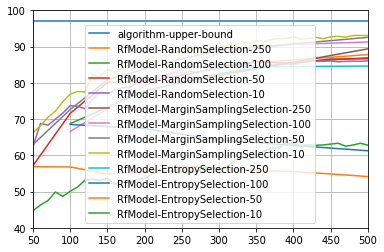

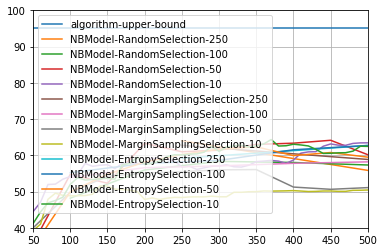

In [0]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend()
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.show()

models_str = ['NBModel','RfModel','SvmModel'] #['SvmModel', 'RfModel', 'LogModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','100','50','10'] #['250','125','50','25','10'] 
repeats = 1
random_forest_upper_bound = 97.
naive_bayes_bound = 95
svm_upper_bound = 94.
log_upper_bound = 92.47
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model? under the stopping condition and hyper parameters - random forest is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(naive_bayes_bound, d, ['NBModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(svm_upper_bound, d, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
#performance_plot(log_upper_bound, d, ['LogModel'] , selection_functions_str    , Ks_str, 1)

So which is the best sample selection function? margin sampling is the winner!


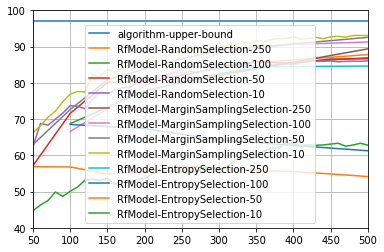


So which is the best k? k=10 is the winner


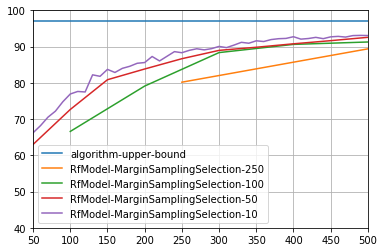

In [0]:
print('So which is the best sample selection function? margin sampling is the winner!')
performance_plot(random_forest_upper_bound, d, ['RfModel'], selection_functions_str    , Ks_str, 1)
print()
print('So which is the best k? k=10 is the winner')
performance_plot(random_forest_upper_bound, d, ['RfModel'] , ['MarginSamplingSelection'], Ks_str, 1)